In [14]:
# ===== Cell 1: Setup & Config =====
import os, shutil, random, pathlib, zipfile
import numpy as np, pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

SEED = 1337
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)
try:
    tf.config.experimental.enable_op_determinism()
except Exception:
    pass

AUTOTUNE   = tf.data.AUTOTUNE
IMG_SIZE   = 224
BATCH_SIZE = 32
EPOCHS     = 15

TRAIN_SIZES = [1000, 1800, 2000]
VAL_N  = 500
TEST_N = 500

# Will be set in Cell 2 after we inspect the folders
CLASS_NAMES = None



In [15]:
# ===== Cell 2: Fresh download to /content + clean val/test split (by COPY) =====
from pathlib import Path

url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"

# 1) Download zip (no auto-extract), then extract fresh into /content/catsdogs_clean
zip_path = keras.utils.get_file("cats_and_dogs_filtered.zip", origin=url, extract=False)
extract_root = Path("/content/catsdogs_clean")
if extract_root.exists():
    shutil.rmtree(extract_root)
extract_root.mkdir(parents=True, exist_ok=True)

with zipfile.ZipFile(zip_path, "r") as zf:
    zf.extractall(extract_root)

# 2) Locate dataset root
data_root = extract_root / "cats_and_dogs_filtered"
train_dir = data_root / "train"
orig_val_dir = data_root / "validation"

assert train_dir.exists(), f"Missing train dir at {train_dir}"
assert orig_val_dir.exists(), f"Missing validation dir at {orig_val_dir}"

# 3) Create our own val/test split from the official validation set
val_dir  = data_root / "val_split"
test_dir = data_root / "test_split"

def reset_dir(d: Path):
    if d.exists():
        shutil.rmtree(d)
    (d / "cats").mkdir(parents=True, exist_ok=True)
    (d / "dogs").mkdir(parents=True, exist_ok=True)

def copy_half_to_val_half_to_test(src_dir: Path, dst_val: Path, dst_test: Path):
    for cname in ["cats", "dogs"]:
        files = sorted((src_dir / cname).glob("*.jpg"))
        half = len(files) // 2
        for p in files[:half]:
            shutil.copy2(p, dst_val / cname / p.name)
        for p in files[half:]:
            shutil.copy2(p, dst_test / cname / p.name)

reset_dir(val_dir); reset_dir(test_dir)
copy_half_to_val_half_to_test(orig_val_dir, val_dir, test_dir)

# 4) Set CLASS_NAMES dynamically (from train)
CLASS_NAMES = sorted([d.name for d in train_dir.iterdir() if d.is_dir() and not d.name.startswith(".")])
print("CLASS_NAMES:", CLASS_NAMES)

def count_two_class(d: Path):
    return {
        "cats": len(list((d / "cats").glob("*.jpg"))),
        "dogs": len(list((d / "dogs").glob("*.jpg")))
    }

tr_cnt = count_two_class(train_dir)
va_cnt = count_two_class(val_dir)
te_cnt = count_two_class(test_dir)

print("DATA ROOT:", data_root)
print("Train dir:", train_dir, tr_cnt, f"({tr_cnt['cats']+tr_cnt['dogs']} images)")
print("Val dir:  ", val_dir,   va_cnt, f"({va_cnt['cats']+va_cnt['dogs']} images)")
print("Test dir: ", test_dir,  te_cnt, f"({te_cnt['cats']+te_cnt['dogs']} images)")


CLASS_NAMES: ['cats', 'dogs']
DATA ROOT: /content/catsdogs_clean/cats_and_dogs_filtered
Train dir: /content/catsdogs_clean/cats_and_dogs_filtered/train {'cats': 1000, 'dogs': 1000} (2000 images)
Val dir:   /content/catsdogs_clean/cats_and_dogs_filtered/val_split {'cats': 250, 'dogs': 250} (500 images)
Test dir:  /content/catsdogs_clean/cats_and_dogs_filtered/test_split {'cats': 250, 'dogs': 250} (500 images)


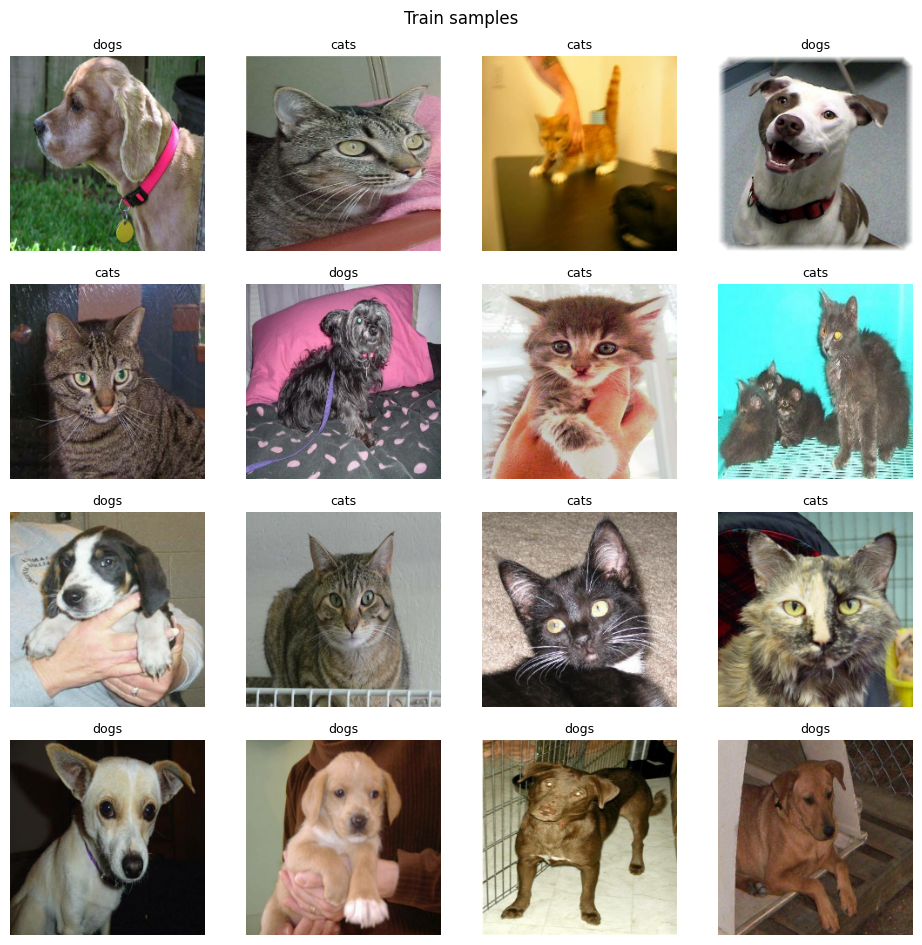

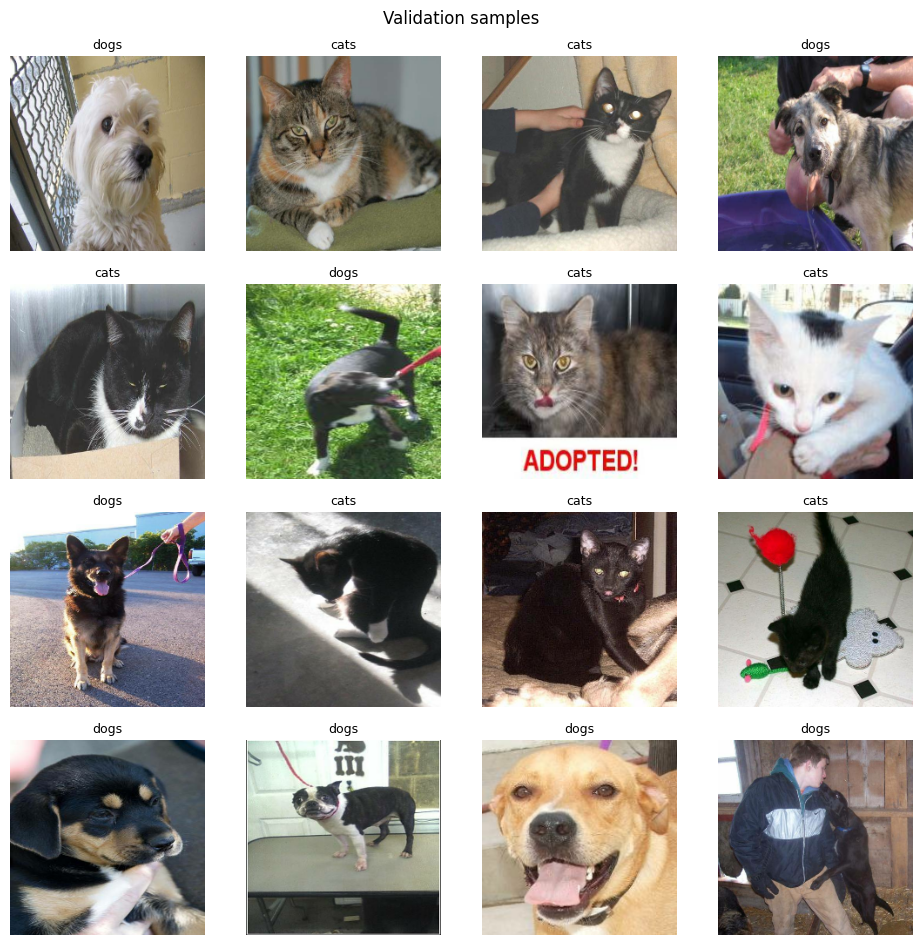

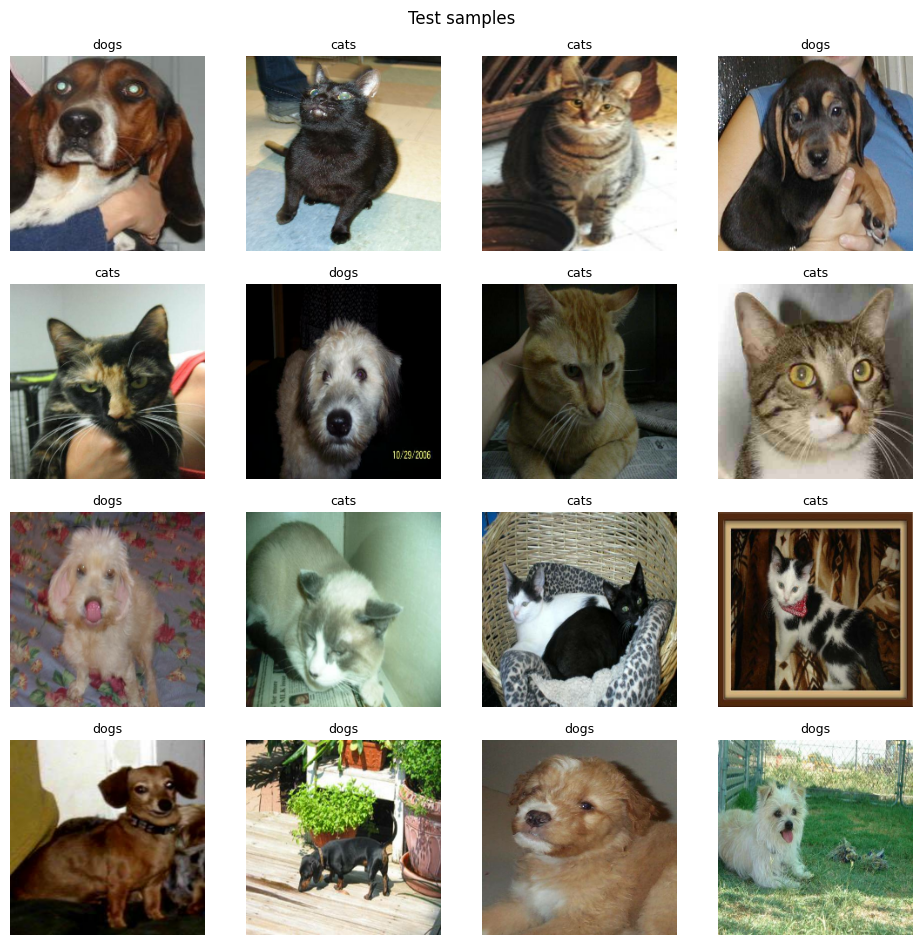

Saved: train_samples.png, val_samples.png, test_samples.png


In [16]:
# ===== Cell 8A: Sample image grids =====
import math, matplotlib.pyplot as plt

def show_grid(files, labels, n=16, title="Samples", save_path=None):
    n = min(n, len(files))
    rows = int(math.sqrt(n)); cols = int(math.ceil(n/rows))
    plt.figure(figsize=(cols*2.4, rows*2.4))
    for i in range(n):
        img = decode_resize(files[i])  # tf.Tensor [H,W,3], float32 in [0,255]
        img = tf.cast(tf.clip_by_value(img, 0, 255), tf.uint8).numpy()
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(img)
        ax.set_title(CLASS_NAMES[labels[i]], fontsize=9)
        ax.axis("off")
    plt.suptitle(title, y=0.98, fontsize=12)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=160)
    plt.show()

# pick small balanced samples from each split
tr_files_s, tr_labels_s = list_balanced_files(train_dir, 16)
va_files_s, va_labels_s = list_balanced_files(val_dir,   16)
te_files_s, te_labels_s = list_balanced_files(test_dir,  16)

show_grid(tr_files_s, tr_labels_s, n=16, title="Train samples", save_path="train_samples.png")
show_grid(va_files_s, va_labels_s, n=16, title="Validation samples", save_path="val_samples.png")
show_grid(te_files_s, te_labels_s, n=16, title="Test samples", save_path="test_samples.png")
print("Saved: train_samples.png, val_samples.png, test_samples.png")


In [4]:
# ===== Cell 3: Data Helpers (balanced sampling, tf.data builder) =====
from typing import List, Tuple

def list_balanced_files(dir_path: Path, desired_total: int, seed: int = SEED) -> Tuple[List[str], List[int]]:
    """
    Returns lists of filepaths (str) and labels (int), balanced across CLASS_NAMES.
    Caps to what's available.
    """
    assert CLASS_NAMES is not None, "CLASS_NAMES not set — run Cell 2 first."
    # available per class
    avail = [len(list((dir_path / cname).glob("*.jpg"))) for cname in CLASS_NAMES]
    k = len(CLASS_NAMES)
    per_class_req = desired_total // k
    per_class = min(per_class_req, *avail)
    if per_class == 0:
        raise ValueError(f"Not enough images in {dir_path} to sample a balanced set.")
    files, labels = [], []
    for idx, cname in enumerate(CLASS_NAMES):
        imgs = sorted((dir_path / cname).glob("*.jpg"))[:per_class]
        files += [str(p) for p in imgs]
        labels += [idx] * len(imgs)
    # deterministic shuffle
    rng = random.Random(seed)
    idxs = list(range(len(files)))
    rng.shuffle(idxs)
    files  = [files[i] for i in idxs]
    labels = [labels[i] for i in idxs]
    return files, labels

def decode_resize(path):
    path = tf.cast(path, tf.string)
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    return img

def make_ds(files, labels, shuffle=False):
    n = len(files)
    assert n > 0, "Empty dataset — check your directories/counts."
    files_t  = tf.convert_to_tensor(files, dtype=tf.string)
    labels_t = tf.convert_to_tensor(labels, dtype=tf.int32)
    ds = tf.data.Dataset.from_tensor_slices((files_t, labels_t))
    ds = ds.map(lambda p, y: (decode_resize(p), y), num_parallel_calls=AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=n, seed=SEED, reshuffle_each_iteration=True)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds


In [5]:
# ===== Cell 4: Augmentation & Models =====
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal", seed=SEED),
    layers.RandomRotation(0.05, seed=SEED),
    layers.RandomZoom(0.1, seed=SEED),
], name="data_augmentation")

def build_scratch_model():
    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)
    x = layers.Conv2D(32, 3, padding="same", activation="relu",
                      kernel_regularizer=keras.regularizers.l2(1e-4))(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, padding="same", activation="relu",
                      kernel_regularizer=keras.regularizers.l2(1e-4))(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, padding="same", activation="relu",
                      kernel_regularizer=keras.regularizers.l2(1e-4))(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs, name="scratch_cnn")
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

def build_pretrained_model(fine_tune=False):
    base = keras.applications.MobileNetV2(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights="imagenet"
    )
    base.trainable = False  # start frozen

    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = data_augmentation(inputs)
    x = keras.applications.mobilenet_v2.preprocess_input(x)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs, name="mobilenetv2_head")
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    if fine_tune:
        base.trainable = True
        for layer in base.layers[:-20]:
            layer.trainable = False
        model.compile(optimizer=keras.optimizers.Adam(1e-4),
                      loss="binary_crossentropy",
                      metrics=["accuracy"])
    return model


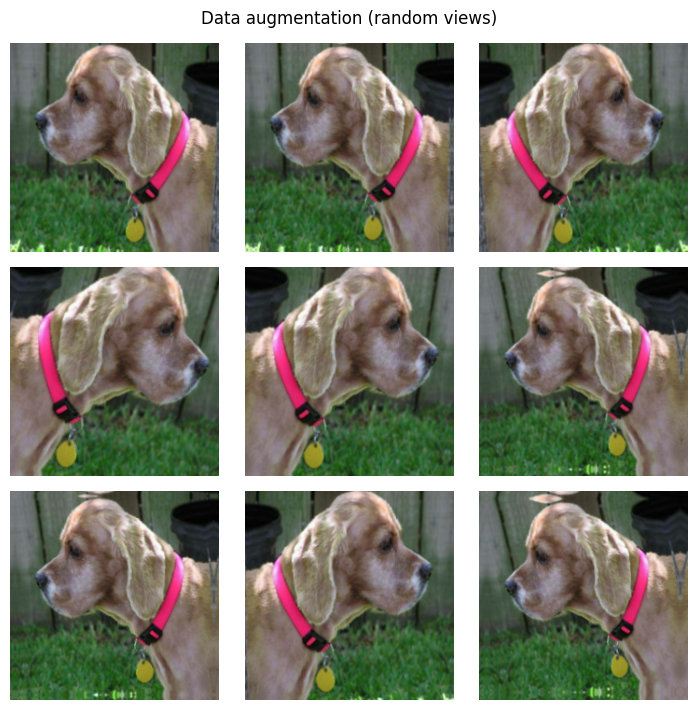

Saved: aug_examples.png


In [17]:
# ===== Cell 8B: Augmentation previews =====
import matplotlib.pyplot as plt

# pick one training image
one_file = tr_files_s[0]
raw = decode_resize(one_file)
raw = tf.cast(tf.clip_by_value(raw, 0, 255), tf.uint8)

# generate k augmented versions
k = 9
aug_imgs = []
for _ in range(k):
    # data_augmentation expects float input; we can cast and expand dims
    x = tf.cast(raw, tf.float32)
    x = tf.expand_dims(x, 0)
    y = data_augmentation(x, training=True)[0]
    y = tf.cast(tf.clip_by_value(y, 0, 255), tf.uint8)
    aug_imgs.append(y.numpy())

# plot grid
rows, cols = 3, 3
plt.figure(figsize=(cols*2.4, rows*2.4))
for i, im in enumerate(aug_imgs):
    ax = plt.subplot(rows, cols, i+1)
    ax.imshow(im)
    ax.axis("off")
plt.suptitle("Data augmentation (random views)", y=0.98, fontsize=12)
plt.tight_layout()
plt.savefig("aug_examples.png", dpi=160)
plt.show()
print("Saved: aug_examples.png")


In [6]:
# ===== Cell 5: run_experiment() =====
def run_experiment(model_type, train_n, fine_tune=False):
    # sample files
    tr_files, tr_labels = list_balanced_files(train_dir, train_n)
    va_files, va_labels = list_balanced_files(val_dir,   VAL_N)
    te_files, te_labels = list_balanced_files(test_dir,  TEST_N)

    print(f"[{model_type}{' + FT' if fine_tune else ''}] "
          f"train={len(tr_files)} val={len(va_files)} test={len(te_files)}")

    # build datasets
    train_ds = make_ds(tr_files, tr_labels, shuffle=True)
    val_ds   = make_ds(va_files, va_labels)
    test_ds  = make_ds(te_files, te_labels)

    # choose model
    model = build_scratch_model() if model_type == "scratch" else build_pretrained_model(fine_tune=fine_tune)

    # early stop on val accuracy
    cb = keras.callbacks.EarlyStopping(
        monitor="val_accuracy", mode="max", patience=3, restore_best_weights=True
    )

    hist = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[cb], verbose=2)

    val_best = float(max(hist.history["val_accuracy"]))
    test_loss, test_acc = model.evaluate(test_ds, verbose=0)

    return {
        "Model": "Pretrained" if model_type == "pretrained" else "From-scratch",
        "Train_N": int(train_n),
        "Val_Accuracy": val_best,
        "Test_Accuracy": float(test_acc),
        "Fine_Tuned": bool(fine_tune)
    }


In [7]:
# ===== Cell 5 (REPLACE): run_experiment() — pass dirs explicitly =====
def run_experiment(model_type, train_n, train_dir, val_dir, test_dir, fine_tune=False):
    # sample files from explicitly provided dirs
    tr_files, tr_labels = list_balanced_files(train_dir, train_n)
    va_files, va_labels = list_balanced_files(val_dir,   VAL_N)
    te_files, te_labels = list_balanced_files(test_dir,  TEST_N)

    print(f"[{model_type}{' + FT' if fine_tune else ''}] "
          f"train={len(tr_files)} val={len(va_files)} test={len(te_files)} | "
          f"dirs: {train_dir} | {val_dir} | {test_dir}")

    # build datasets
    train_ds = make_ds(tr_files, tr_labels, shuffle=True)
    val_ds   = make_ds(va_files, va_labels)
    test_ds  = make_ds(te_files, te_labels)

    # choose model
    model = build_scratch_model() if model_type == "scratch" else build_pretrained_model(fine_tune=fine_tune)

    # early stop on val accuracy
    cb = keras.callbacks.EarlyStopping(
        monitor="val_accuracy", mode="max", patience=3, restore_best_weights=True
    )

    hist = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[cb], verbose=2)

    val_best = float(max(hist.history["val_accuracy"]))
    test_loss, test_acc = model.evaluate(test_ds, verbose=0)

    return {
        "Model": "Pretrained" if model_type == "pretrained" else "From-scratch",
        "Train_N": int(train_n),
        "Val_Accuracy": val_best,
        "Test_Accuracy": float(test_acc),
        "Fine_Tuned": bool(fine_tune)
    }



In [8]:
# ===== Cell 6 (REPLACE): Run Experiments with explicit dirs =====
# Use the dirs created in Cell 2
print("USING DIRS:\n",
      " TRAIN_DIR =", train_dir, "\n",
      "VAL_DIR   =", val_dir,   "\n",
      "TEST_DIR  =", test_dir)

results = []

# From-scratch: all sizes
for n in TRAIN_SIZES:
    results.append(run_experiment("scratch", n, train_dir, val_dir, test_dir, fine_tune=False))

# Pretrained: frozen on first two, fine-tune on largest size
for n in TRAIN_SIZES[:-1]:
    results.append(run_experiment("pretrained", n, train_dir, val_dir, test_dir, fine_tune=False))
results.append(run_experiment("pretrained", TRAIN_SIZES[-1], train_dir, val_dir, test_dir, fine_tune=True))

df = pd.DataFrame(results).sort_values(["Model", "Train_N"]).reset_index(drop=True)
df


USING DIRS:
  TRAIN_DIR = /content/catsdogs_clean/cats_and_dogs_filtered/train 
 VAL_DIR   = /content/catsdogs_clean/cats_and_dogs_filtered/val_split 
 TEST_DIR  = /content/catsdogs_clean/cats_and_dogs_filtered/test_split
[scratch] train=1000 val=500 test=500 | dirs: /content/catsdogs_clean/cats_and_dogs_filtered/train | /content/catsdogs_clean/cats_and_dogs_filtered/val_split | /content/catsdogs_clean/cats_and_dogs_filtered/test_split
Epoch 1/15
32/32 - 12s - 386ms/step - accuracy: 0.4980 - loss: 0.7056 - val_accuracy: 0.5000 - val_loss: 0.6970
Epoch 2/15
32/32 - 5s - 166ms/step - accuracy: 0.5130 - loss: 0.6992 - val_accuracy: 0.6180 - val_loss: 0.6966
Epoch 3/15
32/32 - 5s - 163ms/step - accuracy: 0.5390 - loss: 0.6974 - val_accuracy: 0.6340 - val_loss: 0.6835
Epoch 4/15
32/32 - 10s - 326ms/step - accuracy: 0.5720 - loss: 0.6904 - val_accuracy: 0.5000 - val_loss: 0.7092
Epoch 5/15
32/32 - 11s - 330ms/step - accuracy: 0.5680 - loss: 0.6970 - val_accuracy: 0.5880 - val_loss: 0.6743
Ep

Model  Train_N  Val_Accuracy  Test_Accuracy  Fine_Tuned
0  From-scratch     1000         0.644          0.584       False
1  From-scratch     1800         0.502          0.506       False
2  From-scratch     2000         0.644          0.602       False
3    Pretrained     1000         0.994          0.980       False
4    Pretrained     1800         0.994          0.978       False
5    Pretrained     2000         0.996          0.984        True

In [10]:
# ===== Cell 7: Save Summary to CSV =====
# show a nicely rounded view (for the notebook)
df_view = df.copy()
for col in ["Val_Accuracy", "Test_Accuracy"]:
    df_view[col] = df_view[col].map(lambda x: f"{x:.3f}")
display(df_view)

# save the raw numeric results
df.to_csv("results.csv", index=False)
print("Saved: results.csv")


Model  Train_N Val_Accuracy Test_Accuracy  Fine_Tuned
0  From-scratch     1000        0.644         0.584       False
1  From-scratch     1800        0.502         0.506       False
2  From-scratch     2000        0.644         0.602       False
3    Pretrained     1000        0.994         0.980       False
4    Pretrained     1800        0.994         0.978       False
5    Pretrained     2000        0.996         0.984        True

Saved: results.csv


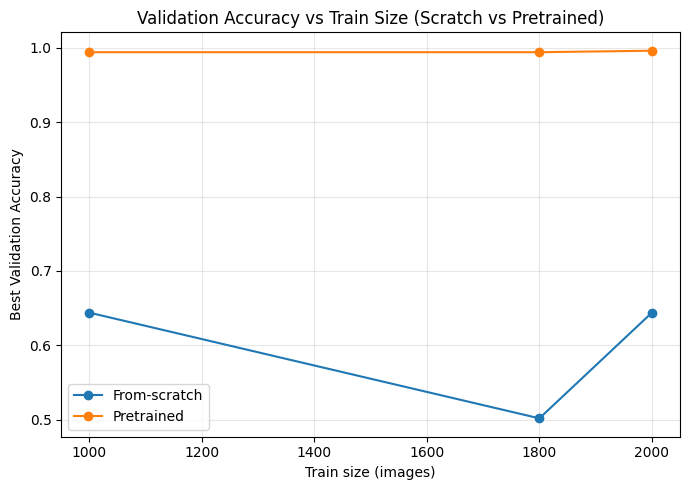

Saved: val_curves.png


<Figure size 700x500 with 0 Axes>

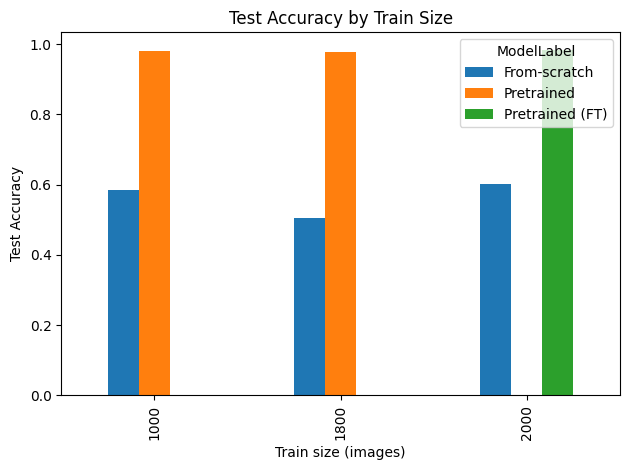

Saved: test_bars.png


In [11]:
# ===== Cell 8: Plots =====
import matplotlib.pyplot as plt

# --- Validation curves (Scratch vs Pretrained) ---
plt.figure(figsize=(7,5))
for model_name in df["Model"].unique():
    g = df[df["Model"] == model_name]
    # For Pretrained, keep the best val per Train_N (fine-tuned may beat frozen)
    if model_name == "Pretrained":
        g = g.groupby("Train_N", as_index=False)["Val_Accuracy"].max()
    plt.plot(g["Train_N"], g["Val_Accuracy"], marker="o", label=model_name)

plt.xlabel("Train size (images)")
plt.ylabel("Best Validation Accuracy")
plt.title("Validation Accuracy vs Train Size (Scratch vs Pretrained)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("val_curves.png", dpi=160)
plt.show()
print("Saved: val_curves.png")

# --- Test accuracy bars (grouped by Train_N) ---
plt.figure(figsize=(7,5))
plot_df = df.copy()
if "Fine_Tuned" in plot_df.columns:
    plot_df["ModelLabel"] = plot_df.apply(
        lambda r: f"{r['Model']}{' (FT)' if r['Fine_Tuned'] else ''}", axis=1
    )
else:
    plot_df["ModelLabel"] = plot_df["Model"]

bar = plot_df.pivot_table(index="Train_N", columns="ModelLabel", values="Test_Accuracy")
ax = bar.plot(kind="bar")  # pandas draws on current figure
ax.set_xlabel("Train size (images)")
ax.set_ylabel("Test Accuracy")
ax.set_title("Test Accuracy by Train Size")
plt.tight_layout()
plt.savefig("test_bars.png", dpi=160)
plt.show()
print("Saved: test_bars.png")


13/13 - 8s - 626ms/step - accuracy: 0.6325 - loss: 0.6239 - val_accuracy: 0.8750 - val_loss: 0.3703


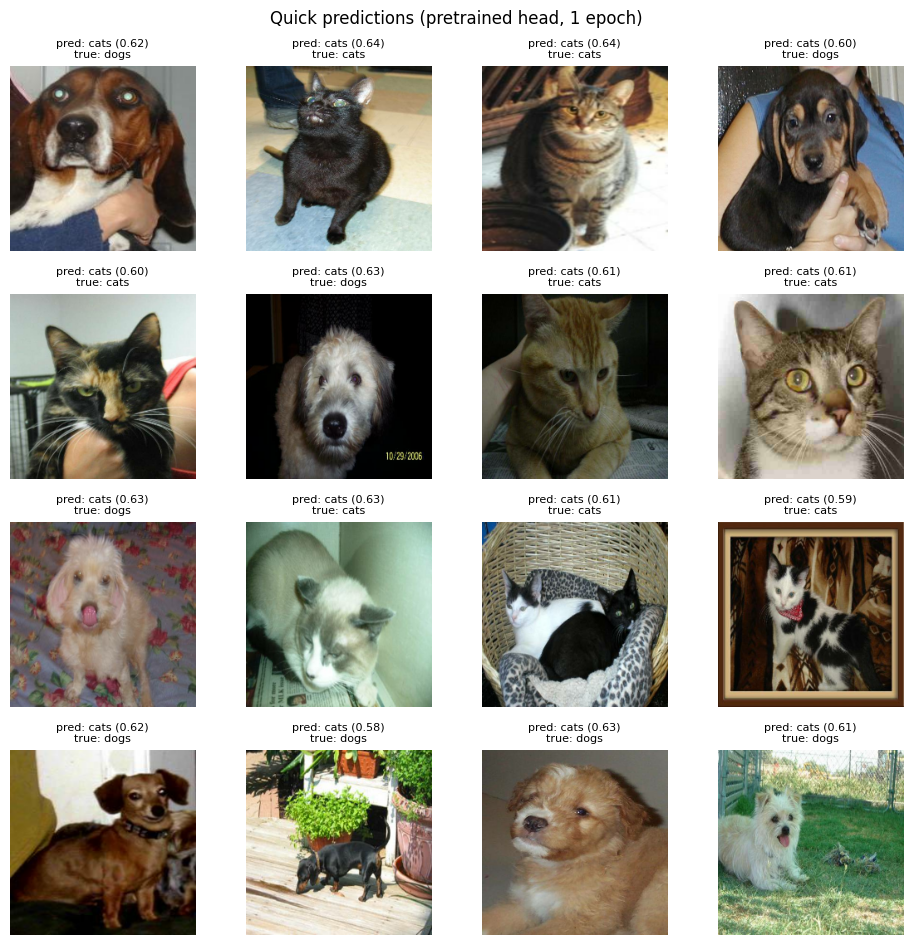

Saved: pred_grid.png


In [18]:
# ===== Cell 8C: Quick prediction grid (fast) =====
# small subset for a quick fit
quick_train_N = min(400, sum(1 for _ in train_dir.rglob("*.jpg")))
qt_files, qt_labels = list_balanced_files(train_dir, quick_train_N)
qv_files, qv_labels = list_balanced_files(val_dir,   min(200, VAL_N))

qt_ds = make_ds(qt_files, qt_labels, shuffle=True)
qv_ds = make_ds(qv_files, qv_labels)

# build a frozen MobileNetV2 head (fast)
qmodel = build_pretrained_model(fine_tune=False)

cb = keras.callbacks.EarlyStopping(monitor="val_accuracy", mode="max", patience=1, restore_best_weights=True)
_ = qmodel.fit(qt_ds, validation_data=qv_ds, epochs=1, verbose=2, callbacks=[cb])

# take 16 test images and predict
n_show = 16
test_show_files, test_show_labels = list_balanced_files(test_dir, n_show)
imgs = []
for p in test_show_files:
    x = decode_resize(p)
    imgs.append(tf.cast(tf.clip_by_value(x, 0, 255), tf.uint8).numpy())

# preprocess for model
inp = tf.stack([keras.applications.mobilenet_v2.preprocess_input(tf.cast(i, tf.float32))
                for i in imgs], axis=0)
probs = qmodel.predict(inp, verbose=0).reshape(-1)
pred_idx = (probs >= 0.5).astype(int)

# plot grid with predicted vs true
import math
rows = 4; cols = 4
plt.figure(figsize=(cols*2.4, rows*2.4))
for i in range(n_show):
    ax = plt.subplot(rows, cols, i+1)
    ax.imshow(imgs[i])
    true_name = CLASS_NAMES[test_show_labels[i]]
    pred_name = CLASS_NAMES[pred_idx[i]]
    conf = probs[i] if pred_idx[i]==1 else (1.0 - probs[i])
    ax.set_title(f"pred: {pred_name} ({conf:.2f})\ntrue: {true_name}", fontsize=8)
    ax.axis("off")
plt.suptitle("Quick predictions (pretrained head, 1 epoch)", y=0.98, fontsize=12)
plt.tight_layout()
plt.savefig("pred_grid.png", dpi=160)
plt.show()
print("Saved: pred_grid.png")


In [12]:
# ===== Cell 9: Download artifacts (Colab) =====
import os
try:
    from google.colab import files
    for p in ["results.csv", "val_curves.png", "test_bars.png"]:
        if os.path.exists(p):
            files.download(p)
except Exception as e:
    print("Download helper not available:", e)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
# ===== Cell 10: Report-friendly summary =====
best_by_model = (df.sort_values("Val_Accuracy", ascending=False)
                   .groupby("Model", as_index=False)
                   .first())[["Model","Train_N","Val_Accuracy","Test_Accuracy","Fine_Tuned"]]
print("Best (by Val_Accuracy) per model family:\n")
print(best_by_model.to_string(index=False))

overall_best = df.iloc[df["Test_Accuracy"].idxmax()]
print("\nOverall best Test Accuracy:")
print(f"  {overall_best.Test_Accuracy:.3f} with {overall_best.Model} "
      f"(Train_N={int(overall_best.Train_N)}"
      f"{' | fine-tuned' if bool(overall_best.Fine_Tuned) else ''}).")


Best (by Val_Accuracy) per model family:

       Model  Train_N  Val_Accuracy  Test_Accuracy  Fine_Tuned
From-scratch     1000         0.644          0.584       False
  Pretrained     2000         0.996          0.984        True

Overall best Test Accuracy:
  0.984 with Pretrained (Train_N=2000 | fine-tuned).
